<a href="https://colab.research.google.com/github/benmsanderson/esm-deck/blob/main/Fair_ESM_DECK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [266]:
%matplotlib inline

In [2]:
#!pip install fair==1.6.4
import fair
from fair.inverse import inverse_fair_scm


In [3]:
import numpy as np
from scipy import stats
from fair.tools.ensemble import tcrecs_generate

from matplotlib import pyplot as plt
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (16, 9)

In [4]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
from fair.SSPs import ssp370, ssp126, ssp585, ssp119

In [51]:
import scipy
from scipy import signal

In [5]:
c_1pct=fair.RCPs.rcp45.Concentrations.co2

In [6]:
# number of prior ensemble members
samples = 500

# generate some joint lognormal TCR and ECS pairs
tcrecs = tcrecs_generate(n=samples, seed=371)

# generate some forcing scale factors with SD of 10% of the best estimate
# Chris: this is over-constrained and probably just something from my example
# Instead let's repeat what we did in FaIR 1.3 code, component by component
# using AR5 scalings
zscore = stats.norm.ppf(0.95)
scales1d = np.array(
    [
        0.2,      # CO2
        0.28,     # CH4: updated value from etminan 2016
        0.2,      # N2O
        0.2,      # other WMGHS
        0.4-0.2,        # tropospheric O3
        -0.05-(-0.15),  # stratospheric O3
        0.07-0.02,      # stratospheric WV from CH4
        1,              # contrails (lognormal)
        0.8/0.9,  # aerosols
        1,      # black carbon on snow (lognormal)
        -0.15-(-0.25),  # land use change
        1.0-0.5,        # volcanic
        0.05
     ]
)/zscore # solar (additive)
scales2d = np.repeat(scales1d[np.newaxis,:],samples,axis=0)

locs = np.array([1,1,1,1,0.4,-0.05,0.07,1,1,1,-0.15,1.0,0.00])
locs2d = np.repeat(locs[np.newaxis,:],samples,axis=0)

# BC-snow and contrails are lognormal with sigma=0.5 and sigma=0.65: see page 8SM-11
F_scale = stats.norm.rvs(size=(samples,13), loc=locs2d[:,:13], scale=scales2d[:,:13], random_state=40000)
F_scale[:,9] = stats.lognorm.rvs(0.5, size=samples, random_state=40001)
F_scale[:,7]  = stats.lognorm.rvs(0.65, size=samples, random_state=40002)

# aerosols are asymmetric Gaussian
F_scale[F_scale[:,8]<-0.9,8] = 1./0.8*(F_scale[F_scale[:,8]<-0.9,8]+0.9) - 0.9


#F_scale = stats.norm.rvs(size=(samples,13), loc=1, scale=0.1, random_state=40000)

# do the same for the carbon cycle parameters
r0 = stats.norm.rvs(size=samples, loc=35, scale=3.5, random_state=41400)
rc = stats.norm.rvs(size=samples, loc=0.019, scale=0.0019, random_state=42400)
rt = stats.norm.rvs(size=samples, loc=4.165, scale=0.4165, random_state=45400)




In [7]:
#extended parameter perturbation

tau=np.zeros((samples,4))
tau[:,0]=stats.lognorm.rvs(0.6, size=samples, random_state=40202)*1e6
tau[:,1]=stats.lognorm.rvs(0.6, size=samples, random_state=40203)*400
tau[:,2]=stats.lognorm.rvs(0.6, size=samples, random_state=40204)*100
tau[:,3]=stats.lognorm.rvs(0.6, size=samples, random_state=40205)*5
q=np.zeros((samples,3))

q[:,0]=stats.lognorm.rvs(0.6, size=samples, random_state=40206)*.5
q[:,1]=stats.lognorm.rvs(0.6, size=samples, random_state=40207)*.33
q[:,2]=stats.lognorm.rvs(0.6, size=samples, random_state=40208)*.41
d=np.zeros((samples,3))

d[:,0]=stats.lognorm.rvs(0.65, size=samples, random_state=40006)*3000
d[:,1]=stats.lognorm.rvs(0.65, size=samples, random_state=40007)*200
d[:,2]=stats.lognorm.rvs(0.65, size=samples, random_state=40008)*4


In [8]:
def calc_ecs(q):
  ecs=3.72*np.sum(q)
  return ecs

In [9]:
def get_zec(r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4]),F2x=3.71):
    #nt = 70 # years
    qm= np.repeat(q[np.newaxis,:],300,axis=0)
    C  = 278. * 1.01**np.arange(300) # compound 1% increase in CO2 concentrations
    # run with default carbon cycle parameters
    E1, F1, T1 = inverse_fair_scm(C=C,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm,F2x=F2x)
    nt=np.argmax(np.cumsum(E1)>1000)
    emms=np.zeros((300))
    emms[:nt]=E1[:nt]

    C,F,T=fair.forward.fair_scm(emissions=emms,useMultigas=False,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm,F2x=F2x)
    zec50=T[nt+50]-T[nt]
    zec100=T[nt+100]-T[nt]
    tcre=T[nt]
    tcr=T[70]
    af=((C[70]-C[0])*2.13)/np.sum(E1[:70])

    return C,F,T,emms,zec50,zec100,tcre,tcr,af

In [10]:
_,_,_,_,_,_,_,tmptcr,tmpaf=get_zec()

In [11]:
tmpaf

0.46964272625348413

In [12]:
def charlie_blip(nt=3000,r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4]),tb=45,ta=1000, tpeak_fact=3.33333,F2x=3.71):
    #nt=3000

    if tpeak_fact > 0:
        tpeak = tb*tpeak_fact
    else:
        tpeak = -tpeak_fact

    time = np.arange(0,nt)
    emms = (ta*(tpeak-time)*np.exp(-((tpeak-time)**2.)/(2*tb**2.)))/(tb**2.)
    #emms=ta*2*(-(np.arange(0,nt)-(tpeak)))/np.square(tb)*np.exp(-(np.square((np.arange(0,nt)-(tpeak))/tb)))

    emms[int(tpeak*2):] = 0.


    qm= np.repeat(q[np.newaxis,:],nt,axis=0)

    C,F,T=fair.forward.fair_scm(emissions=emms,useMultigas=False,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm,F2x=F2x)


    return C,F,T,emms

In [13]:
def zec_bump(nt=3000,r0=35,rc=0.019,rt=4.165,tcrecs=np.array([1.75,3]),tau = np.array([1e6, 400.0, 100.0, 5.0]),a   = np.ones(4) * 0.25,iirf_h=100,d=np.array([239,4.1]),q=np.array([0.6,0.4]),tb=45,ta=1000, tpeak_fact=3.33333,F2x=3.71):
    #nt=3000

    if tpeak_fact > 0:
        tpeak = tb*tpeak_fact
    else:
        tpeak = -tpeak_fact

    time = np.arange(0,nt)
    emms = 10*np.exp(-((tpeak-time)**2.)/(2*tb**2.))
    #emms=ta*2*(-(np.arange(0,nt)-(tpeak)))/np.square(tb)*np.exp(-(np.square((np.arange(0,nt)-(tpeak))/tb)))

    emms[int(tpeak*2):] = 0.


    qm= np.repeat(q[np.newaxis,:],nt,axis=0)

    C,F,T=fair.forward.fair_scm(emissions=emms,useMultigas=False,r0=r0,rc=rc,rt=rt,tcrecs=tcrecs,tau=tau,a=a,iirf_h=iirf_h,d=d,q=qm,F2x=F2x)


    return C,F,T,emms

In [14]:
def calc_tcr(q,d):
  tcp=q*0
  for i,m in enumerate(q):
    tcp[i]=3.72*(q[i]*(1-d[i]/70*(1-np.exp(-70/d[i]))))
  tcr=np.sum(tcp)
  return tcr

In [15]:
from fair.temperature.millar import calculate_q
ec_q=np.zeros((2,samples))
for i in range(samples):
  ec_q[:,i]=calculate_q(tcrecs[i,:],fair.forward.thermal.d,3.7,70,1)

In [16]:
T = np.zeros((736,samples))
F = np.zeros((736,samples))
C = np.zeros((736,31,samples))

To = np.zeros((736,samples))
Fo = np.zeros((736,samples))
Co = np.zeros((736,31,samples))
#Run SSP3 basline ensemble to calibrate plausible FAIR parameters (Extended)

for i in range(samples):
    C[:,:,i], _, T[:,i] = fair.forward.fair_scm(emissions=ssp370.Emissions.emissions,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        scale = F_scale[i,:],
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:]
                                                )



/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [17]:
E1pc = np.zeros((140,samples))

C1  = 278. * 1.01**np.arange(140) # compound 1% increase in CO2 concentrations
for i in range(samples):
    E1pc[:,i],_,_ = inverse_fair_scm(C=C1,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])

In [18]:
E1pc.shape

(140, 500)

In [19]:
from urllib.request import urlopen



from fair.tools.constrain import hist_temp

# load up Cowtan and Way data remotely
url = 'http://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt'
response = urlopen(url)

CW = np.loadtxt(response)
constrained = np.zeros(samples, dtype=bool)
constrained_org = np.zeros(samples, dtype=bool)

issmth=np.max(np.abs(np.diff(E1pc.T)[:,3:]),axis=1)<.5
for i in range(samples):
    # we use observed trend from 1880 to 2016
    constrained[i], _, _, _, _ = hist_temp(CW[30:167,1], T[1880-1765:2017-1765,i], CW[30:167,0])

isgd=[i for i, x in enumerate(np.logical_and(constrained,issmth)) if x]
# How many ensemble members passed the constraint?
print('%d ensemble members passed historical constraint' % len(isgd))

28 ensemble members passed historical constraint


In [20]:
zec50arr = np.zeros((len(isgd)))
zec100arr = np.zeros((len(isgd)))

tcrearr = np.zeros((len(isgd)))
tcrarr = np.zeros((len(isgd)))
afarr = np.zeros((len(isgd)))

for n,i in enumerate(isgd):
    _,_,_,_,zec50arr[n],zec100arr[n],tcrearr[n],tcrarr[n],afarr[n]=get_zec(r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=q[np.newaxis,i,:],
                        d=d[i,:])


In [50]:

nt = 140 # years

E1 = np.zeros((140,len(isgd)))
T1 = np.zeros((140,len(isgd)))

fig = plt.figure()

# run with default carbon cycle parameters
C  = 278. * 1.01**np.arange(nt) # compound 1% increase in CO2 concentrations
for n,i in enumerate(isgd):
    E1[:,n],_,T1[:,n] = inverse_fair_scm(C=C,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])

Ccdr  = np.concatenate([C,np.flip(C)]) # compound 1% increase in CO2 concentrations
Ecdr = np.zeros((280,len(isgd)))
Tcdr = np.zeros((280,len(isgd)))

for n,i in enumerate(isgd):
    Ecdr[:,n],_,Tcdr[:,n] = inverse_fair_scm(C=Ccdr,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])

Cabr  = np.concatenate([[C[0]],C[0]*4*np.ones(139)]) # compound 1% increase in CO2 concentrations
Eabr = np.zeros((140,len(isgd)))
Tabr = np.zeros((140,len(isgd)))

for n,i in enumerate(isgd):
    Eabr[:,n],_,Tabr[:,n] = inverse_fair_scm(C=Cabr,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])

Crev  = np.concatenate([[C[0]],C[0]*4*np.ones(139),C[0]*np.ones(140)]) # compound 1% increase in CO2 concentrations
Erev = np.zeros((280,len(isgd)))
Trev = np.zeros((280,len(isgd)))

for n,i in enumerate(isgd):
    Erev[:,n],_,Trev[:,n] = inverse_fair_scm(C=Crev,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])



/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


<Figure size 1152x648 with 0 Axes>

In [67]:

Ezec = np.zeros((300,len(isgd)))
Czec = np.zeros((300,len(isgd)))
Tzec = np.zeros((300,len(isgd)))

for n,i in enumerate(isgd):
    Czec[:,n],_,Tzec[:,n],Ezec[:,n],_,_,_,_,_ = get_zec(
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=q[i,:],
                        d=d[i,:])

Cchr = np.zeros((300,len(isgd)))
Tchr = np.zeros((300,len(isgd)))

for n,i in enumerate(isgd):
    Cchr[:,n],_,Tchr[:,n],Echr = charlie_blip(nt=300,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=q[i,:],
                        d=d[i,:])


/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [25]:
Ecns  = np.ones(150)*10
Ccns = np.zeros((150,len(isgd)))
Tcns = np.zeros((150,len(isgd)))
tcre_flat=np.zeros(len(isgd))
for n,i in enumerate(isgd):
    Ccns[:,n],_,Tcns[:,n] = fair.forward.fair_scm(emissions=Ecns,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])
    tcre_flat[n]=Tcns[99,n]

In [26]:
Ecn0  = np.concatenate([np.ones(100)*10,np.zeros(220)])
Ccn0 = np.zeros((320,len(isgd)))
Tcn0 = np.zeros((320,len(isgd)))

zec50_flat=np.zeros(len(isgd))

zec100_flat=np.zeros(len(isgd))

for n,i in enumerate(isgd):
    Ccn0[:,n],_,Tcn0[:,n] = fair.forward.fair_scm(emissions=Ecn0,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])
    zec100_flat[n]=Tcn0[200,n]-Tcn0[100,n]
    zec50_flat[n]=Tcn0[150,n]-Tcn0[100,n]

Czb = np.zeros((300,len(isgd)))
Tzb = np.zeros((300,len(isgd)))

for n,i in enumerate(isgd):
    Czb[:,n],_,Tzb[:,n],Ezb = zec_bump(nt=300,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=q[i,:],
                        d=d[i,:])

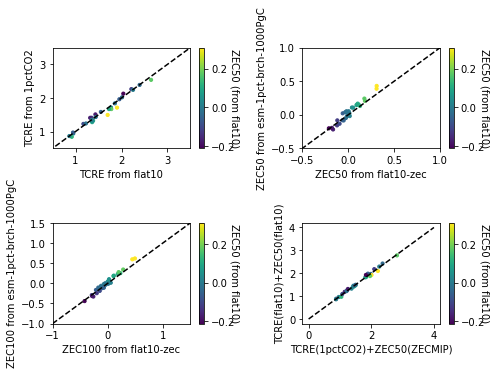

In [27]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(221)
ax1.set_ylabel('TCRE from 1pctCO2')
ax1.set_xlabel('TCRE from flat10')
ax1.set_xlim([0.5,3.5])
ax1.set_ylim([0.5,3.5])


c1=ax1.scatter(tcre_flat,tcrearr,10,zec50_flat.T)
ax1.plot([0,4],[0,4],'k--')
cbar = plt.colorbar(c1)
cbar.set_label('ZEC50 (from flat10)', rotation=270)

ax2 = fig.add_subplot(222)
c1=ax2.scatter(zec50_flat,zec50arr,10,zec50_flat.T)
ax2.plot([-1,1],[-1,1],'k--')
ax2.set_ylabel('ZEC50 from esm-1pct-brch-1000PgC')
ax2.set_xlabel('ZEC50 from flat10-zec')
ax2.set_xlim([-.5,1])
ax2.set_ylim([-.5,1])
cbar = plt.colorbar(c1)
cbar.set_label('ZEC50 (from flat10)', rotation=270)

ax3 = fig.add_subplot(223)
c1=ax3.scatter(zec100_flat,zec100arr,10,zec50_flat.T)
ax3.plot([-1,1.5],[-1,1.5],'k--')

ax3.set_ylabel('ZEC100 from esm-1pct-brch-1000PgC')
ax3.set_xlabel('ZEC100 from flat10-zec')
ax3.set_xlim([-1,1.5])
ax3.set_ylim([-1,1.5])

cbar = plt.colorbar(c1)
cbar.set_label('ZEC50 (from flat10)', rotation=270)
ax4 = fig.add_subplot(224)
c1=ax4.scatter(tcre_flat+zec50_flat,tcrearr+zec50arr,10,zec50_flat.T)
ax4.plot([0,4],[0,4],'k--')

ax4.set_ylabel('TCRE(flat10)+ZEC50(flat10)')
ax4.set_xlabel('TCRE(1pctCO2)+ZEC50(ZECMIP)')
plt.tight_layout()
fig.canvas.draw()
cbar = plt.colorbar(c1)
cbar.set_label('ZEC50 (from flat10)', rotation=270)


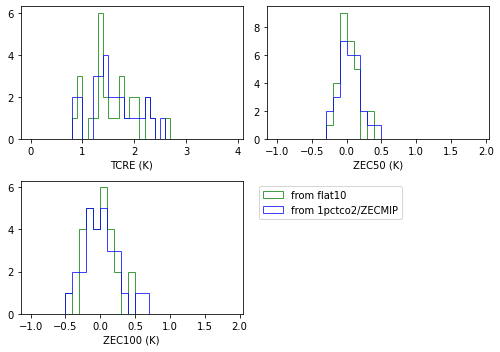

In [28]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(221)



ax1.hist(tcre_flat,np.arange(0,4,0.1),  histtype='step', edgecolor='g',
               alpha=0.75)
ax1.hist(tcrearr,np.arange(0,4,0.1),  histtype='step', edgecolor='b',
               alpha=0.75)

ax1.set_xlabel('TCRE (K)')

ax2 = fig.add_subplot(222)



ax2.hist(zec50_flat,np.arange(-1,2,0.1),  histtype='step', edgecolor='g',
               alpha=0.75)
ax2.hist(zec50arr,np.arange(-1,2,0.1),  histtype='step', edgecolor='b',
               alpha=0.75)

ax2.set_xlabel('ZEC50 (K)')

ax3 = fig.add_subplot(223)



c1=ax3.hist(zec100_flat,np.arange(-1,2,0.1),  histtype='step', edgecolor='g',
               alpha=0.75, label='from flat10')
c2=ax3.hist(zec100arr,np.arange(-1,2,0.1),  histtype='step', edgecolor='b',
               alpha=0.75, label='from 1pctco2/ZECMIP')

ax3.set_xlabel('ZEC100 (K)')




plt.tight_layout()
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [29]:
Ecdf  = np.concatenate([np.ones(100)*10,np.arange(9.9,-10,-.2),np.ones(100)*-10,np.zeros(20)])
Ccdf = np.zeros((320,len(isgd)))
Tcdf = np.zeros((320,len(isgd)))

for n,i in enumerate(isgd):
    Ccdf[:,n],_,Tcdf[:,n] = fair.forward.fair_scm(emissions=Ecdf,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])



In [30]:
Ecdi  = np.concatenate([np.ones(100)*10,np.ones(100)*-10,np.ones(100)*0])
Ccdi = np.zeros((300,len(isgd)))
Tcdi = np.zeros((300,len(isgd)))

for n,i in enumerate(isgd):
    Ccdi[:,n],_,Tcdi[:,n] = fair.forward.fair_scm(emissions=Ecdi,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])



In [31]:
Ejoos  = np.concatenate([[0],[100],np.zeros(278)])
Cjoos = np.zeros((280,len(isgd)))
Tjoos = np.zeros((280,len(isgd)))

for n,i in enumerate(isgd):
    Cjoos[:,n],_,Tjoos[:,n] = fair.forward.fair_scm(emissions=Ejoos,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])
Ejoosr  = np.concatenate([[0],[100],np.zeros(99),[-100],np.zeros(178)])
Cjoosr = np.zeros((280,len(isgd)))
Tjoosr = np.zeros((280,len(isgd)))

for n,i in enumerate(isgd):
    Cjoosr[:,n],_,Tjoosr[:,n] = fair.forward.fair_scm(emissions=Ejoosr,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])

In [32]:
Ejoos1  = np.concatenate([[0],[1],np.zeros(278)])
Cjoos1 = np.zeros((280,len(isgd)))
Tjoos1 = np.zeros((280,len(isgd)))

for n,i in enumerate(isgd):
    Cjoos1[:,n],_,Tjoos1[:,n] = fair.forward.fair_scm(emissions=Ejoos1,
                        useMultigas=False,
                        r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:])


In [33]:
T1pc = np.zeros((140,len(isgd)))
F1pc=3.71*np.arange(0,140)/70
for n,i in enumerate(isgd):
  _,F,T1pc[:,n] = fair.forward.fair_scm(
    emissions=False,
    other_rf=F1pc*F_scale[i,0],
    useMultigas=False,r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:]
)

In [34]:
T2x = np.zeros((300,len(isgd)))
F2x=np.hstack((0,np.ones(299)))
for n,i in enumerate(isgd):
  _,F,T2x[:,n] = fair.forward.fair_scm(
    emissions=False,
    other_rf=F2x*3.71*F_scale[i,0],
    useMultigas=False,r0 = r0[i],
                        rc = rc[i],
                        rt = rt[i],
                        tcrecs = None,
                        F2x = 3.71*F_scale[i,0],
                        tau=tau[i,:],
                        q=np.repeat(q[np.newaxis,i,:],len(ssp370.Emissions.emissions),axis=0),
                        d=d[i,:]
)


In [35]:
Tnz=Tcdf[150,:]-Tcn0[125,:]
TR1000=Tcdf[200,:]-Tcn0[100,:]
TR0=Tcdf[299,:]
TPW=Tcdf.argmax(axis=0)-150

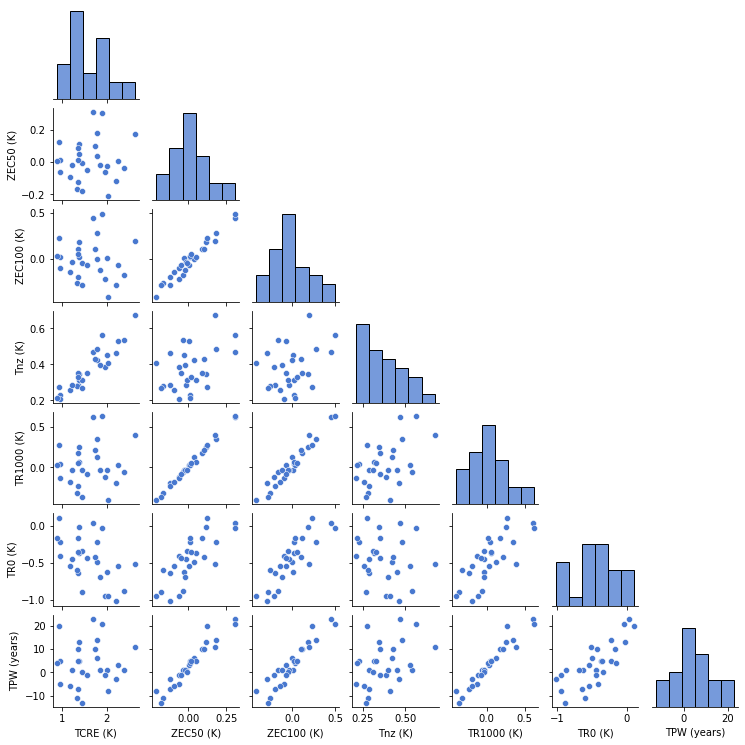

In [40]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'TCRE (K)': tcre_flat,
               'ZEC50 (K)': zec50_flat,
               'ZEC100 (K)':zec100_flat,
               'Tnz (K)': Tnz,
               'TR1000 (K)':TR1000,
                   'TR0 (K)':TR0,
                   'TPW (years)':TPW})

#g = pd.plotting.scatter_matrix(df, figsize=(10,10), marker = '.', hist_kwds = {'bins': 10}, s = 60, alpha = 0.8,corner=True)
sns.pairplot(df, corner=True, height=1.5)

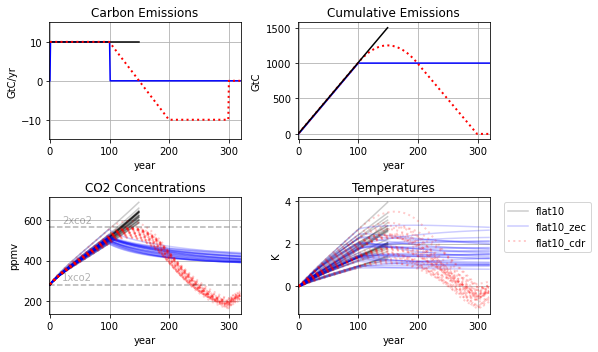

In [41]:
fig = plt.figure(figsize=[7,5])

ax4 = fig.add_subplot(2,2,1)
p131=ax4.plot(range(321), np.concatenate([[0],Ecn0]), color='blue', label='1pctCO2')
p132=ax4.plot(range(150), Ecns, color='k', label='1pctCO2')
#p134=ax4.plot(range(300), Ecdi, color='y', label='1pctCO2',linestyle=':',linewidth=2)
p133=ax4.plot(range(320), Ecdf, color='r', label='1pctCO2',linestyle=':',linewidth=2)


ax4.set_title("Carbon Emissions")
ax4.set_xlabel('year')
ax4.set_ylabel('GtC/yr')
ax4.set_ylim([-15,15])
ax4.set_xlim([-1,320])
ax4.set_xticks([0,100,200,300])

ax4.grid()


ax4c = fig.add_subplot(2,2,2)
p141=ax4c.plot(range(321), np.cumsum(np.concatenate([[0],Ecn0]),0), color='blue', label='1pctCO2')
p143=ax4c.plot(range(320), np.cumsum(Ecdf,0), color='r', label='1pctCO2',linestyle=':',linewidth=2)
p142=ax4c.plot(range(150), np.cumsum(Ecns,0), color='k', label='1pctCO2')
#p144=ax4c.plot(range(300), np.cumsum(Ecdi,0), color='y', label='1pctCO2',linestyle=':',linewidth=2)

#ax4c.legend([p2[0],p1[0],p3[0]],['flat10','flat10_zec','flat10_cdr'])

ax4c.set_title("Cumulative Emissions")
ax4c.set_xlabel('year')
ax4c.set_ylabel('GtC')
ax4c.set_xlim([-1,320])
ax4c.set_xticks([0,100,200,300])

ax4c.grid()


ax42 = fig.add_subplot(2,2,3)
p153=ax42.plot(range(150), Ccns, alpha=0.2, color='k', label='1pctCO2')

p151=ax42.plot(range(320), Ccn0, alpha=0.2, color='blue', label='1pctCO2')
p152=ax42.plot(range(320), Ccdf, alpha=0.2, color='r', label='1pctCO2',linestyle=':',linewidth=2)
###p152=ax42.plot(range(300), Ccdi, alpha=0.2, color='y', label='1pctCO2',linestyle=':',linewidth=2)

ax42.grid()
ax42.axhline(y=Ccns[0,0], color='k',linestyle='--', label='1xco2',alpha=0.3)
plt.text(20,Ccns[0,0]+20,'1xco2',alpha=0.3)
ax42.axhline(y=Ccns[0,0]*2, color='k',linestyle='--', label='1xco2',alpha=0.3)
plt.text(20,Ccns[0,0]*2+20,'2xco2',alpha=0.3)

ax42.set_title("CO2 Concentrations")
ax42.set_xlabel('year')
ax42.set_ylabel('ppmv')
ax42.set_xlim([-1,320])
ax42.set_xticks([0,100,200,300])

ax43 = fig.add_subplot(2,2,4)
p163=ax43.plot(range(150), Tcns, alpha=0.2, color='k', label='1pctCO2')
#p164=ax43.plot(range(300), Tcdi, alpha=0.2, color='y', label='1pctCO2',linestyle=':',linewidth=2)
p161=ax43.plot(range(320), Tcn0, alpha=0.2, color='blue', label='1pctCO2')
p162=ax43.plot(range(320), Tcdf, alpha=0.2, color='r', label='1pctCO2',linestyle=':',linewidth=2)
ax43.grid()

ax43.set_title("Temperatures")
ax43.set_xlabel('year')
ax43.set_ylabel('K')
ax43.set_xlim([-1,320])
ax43.set_xticks([0,100,200,300])



plt.tight_layout()
ax43.legend([p163[0],p161[0],
             p162[0]],['flat10','flat10_zec','flat10_cdr'],bbox_to_anchor=(1.05, 1), loc='upper left')


In [43]:
if 0:

  with open('flat10.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['#Emission rates for flat10 experiment (PgC per year).'])
    writer.writerow(['#CO2 is emitted for 100 years. Followed by 200 years of zero emissions.'])
    writer.writerow(['#Generated by Benjamin Sanderson Sep 21 2023. benjamin.sanderson@cicero.oslo.no'])
    writer.writerow(['#'])
    writer.writerow(['Time (years)','Emission Rate (PgC a-1)'])
    for i,em in enumerate(Ecns):
    # write the data
      writer.writerow([i+0.5,"%.2f" %em])


  with open('flat10_cdr.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['#Emission rates for flat10 experiment (PgC per year).'])
    writer.writerow(['#CO2 is emitted for 100 years. Followed by 200 years of zero emissions.'])
    writer.writerow(['#Generated by Benjamin Sanderson Sep 21 2023. benjamin.sanderson@cicero.oslo.no'])
    writer.writerow(['#'])
    writer.writerow(['Time (years)','Emission Rate (PgC a-1)'])
    for i,em in enumerate(Ecdf):
    # write the data
      writer.writerow([i+0.5,"%.2f" %em])


  with open('flat10_zec.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['#Emission rates for flat10 experiment (PgC per year).'])
    writer.writerow(['#CO2 is emitted for 100 years. Followed by 200 years of zero emissions.'])
    writer.writerow(['#Generated by Benjamin Sanderson Sep 21 2023. benjamin.sanderson@cicero.oslo.no'])
    writer.writerow(['#'])
    writer.writerow(['Time (years)','Emission Rate (PgC a-1)'])
    for i,em in enumerate(Ecn0):
    # write the data
      writer.writerow([i+0.5,"%.2f" %em])

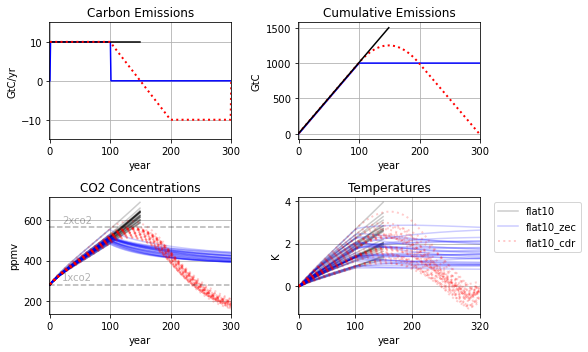

In [44]:
fig = plt.figure(figsize=[7,5])

ax4 = fig.add_subplot(2,2,1)
p131=ax4.plot(range(321), np.concatenate([[0],Ecn0]), color='blue', label='1pctCO2')
p132=ax4.plot(range(150), Ecns, color='k', label='1pctCO2')
#p134=ax4.plot(range(300), Ecdi, color='y', label='1pctCO2',linestyle=':',linewidth=2)
p133=ax4.plot(range(320), Ecdf, color='r', label='1pctCO2',linestyle=':',linewidth=2)


ax4.set_title("Carbon Emissions")
ax4.set_xlabel('year')
ax4.set_ylabel('GtC/yr')
ax4.set_ylim([-15,15])
ax4.set_xlim([-1,300])
ax4.set_xticks([0,100,200,300])

ax4.grid()


ax4c = fig.add_subplot(2,2,2)
p141=ax4c.plot(range(321), np.cumsum(np.concatenate([[0],Ecn0]),0), color='blue', label='1pctCO2')
p143=ax4c.plot(range(320), np.cumsum(Ecdf,0), color='r', label='1pctCO2',linestyle=':',linewidth=2)
p142=ax4c.plot(range(150), np.cumsum(Ecns,0), color='k', label='1pctCO2')
#p144=ax4c.plot(range(300), np.cumsum(Ecdi,0), color='y', label='1pctCO2',linestyle=':',linewidth=2)

#ax4c.legend([p2[0],p1[0],p3[0]],['flat10','flat10_zec','flat10_cdr'])

ax4c.set_title("Cumulative Emissions")
ax4c.set_xlabel('year')
ax4c.set_ylabel('GtC')
ax4c.set_xlim([-1,300])
ax4c.set_xticks([0,100,200,300])

ax4c.grid()


ax42 = fig.add_subplot(2,2,3)
p153=ax42.plot(range(150), Ccns, alpha=0.2, color='k', label='1pctCO2')

p151=ax42.plot(range(320), Ccn0, alpha=0.2, color='blue', label='1pctCO2')
p152=ax42.plot(range(320), Ccdf, alpha=0.2, color='r', label='1pctCO2',linestyle=':',linewidth=2)
###p152=ax42.plot(range(300), Ccdi, alpha=0.2, color='y', label='1pctCO2',linestyle=':',linewidth=2)

ax42.grid()
ax42.axhline(y=Ccns[0,0], color='k',linestyle='--', label='1xco2',alpha=0.3)
plt.text(20,Ccns[0,0]+20,'1xco2',alpha=0.3)
ax42.axhline(y=Ccns[0,0]*2, color='k',linestyle='--', label='1xco2',alpha=0.3)
plt.text(20,Ccns[0,0]*2+20,'2xco2',alpha=0.3)

ax42.set_title("CO2 Concentrations")
ax42.set_xlabel('year')
ax42.set_ylabel('ppmv')
ax42.set_xlim([-1,300])
ax42.set_xticks([0,100,200,300])

ax43 = fig.add_subplot(2,2,4)
p163=ax43.plot(range(150), Tcns, alpha=0.2, color='k', label='1pctCO2')
#p164=ax43.plot(range(300), Tcdi, alpha=0.2, color='y', label='1pctCO2',linestyle=':',linewidth=2)
p161=ax43.plot(range(320), Tcn0, alpha=0.2, color='blue', label='1pctCO2')
p162=ax43.plot(range(320), Tcdf, alpha=0.2, color='r', label='1pctCO2',linestyle=':',linewidth=2)
ax43.grid()

ax43.set_title("Temperatures")
ax43.set_xlabel('year')
ax43.set_ylabel('K')
ax43.set_xlim([-1,320])
ax43.set_xticks([0,100,200,320])



plt.tight_layout()
ax43.legend([p163[0],p161[0],
             p162[0]],['flat10','flat10_zec','flat10_cdr'],bbox_to_anchor=(1.05, 1), loc='upper left')


In [46]:
def tfun(x,t):
  out=x[0]*t*np.exp(-t/x[1])+((1-np.exp(-t/x[2]))*x[3])+t*x[4]
  return out

In [48]:
def residfun(x,trg,e):
  impls=signal.convolve(tfun(x,np.arange(0,len(trg)))/100,e)
  out=np.sum((impls[:len(trg)]-trg)**2)
  return out

In [52]:
residfun([.1,2,1,.2,0.0005],Tcn0[:,0],Ecn0)


144.21253482816738

In [57]:

opt=scipy.optimize.minimize(lambda x: residfun(x,Tcn0[:,0],Ecn0), [.1,3,1,.2,0.0005])

/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/sanderson/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


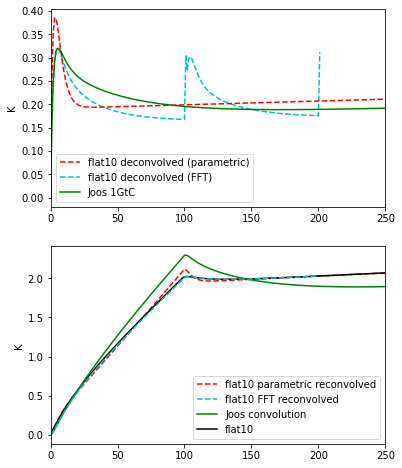

In [59]:
fig=plt.figure(figsize=[6,8])
ax1 = fig.add_subplot(211)
filt=signal.deconvolve(np.hstack([0,Tcn0[:300,0]]), Ecn0[:100])[0]
p0=plt.plot(filt*100,'c--')
p1=ax1.plot(tfun(opt.x,np.arange(0,300)),'r--')
p2=ax1.plot(Tjoos[:,0],'g')
#plt.plot(Tjoos1[:,0]*100)
ax1.set_xlim([0,250])
ax1.set_ylabel('K')
ax1.legend([p1[0],p0[0],p2[0]],['flat10 deconvolved (parametric)','flat10 deconvolved (FFT)','Joos 1GtC'])

ax2 = fig.add_subplot(212)

testim=signal.convolve(tfun(opt.x,np.arange(0,300))/100,Ecn0[:])[:300]
p1=ax2.plot(testim,'r--')
p3=ax2.plot(Tcn0[:,0],'k')
p2=ax2.plot(signal.convolve(Ecn0[:],Tjoos[:,0]/100),'g')
p0=plt.plot(signal.convolve(Ecn0[:],filt)[:200],'c--')
ax2.set_xlim([0,250])
ax2.set_ylabel('K')
ax2.legend([p1[0],p0[0],p2[0],p3[0]],['flat10 parametric reconvolved','flat10 FFT reconvolved','Joos convolution','flat10'])



In [60]:
def sfun(x,t):
  out=x[0]*(1-np.exp(-t/x[1]))+x[2]*(1-np.exp(-t/x[3]))+x[4]*(1-np.exp(-t/x[5]))
  return out

In [61]:
def sresidfun(x,trg,f):
  impls=signal.convolve(sfun(x,np.arange(0,len(trg))),f)
  out=np.sum((impls[:len(trg)]-trg)**2)
  return out

In [62]:

F0=5.35*np.log(Ccn0[:,0]/Ccn0[0,0])

In [63]:
bnds = ((0., 10.), (.1, 10.),(0.,10.),(10.,100.),(0.,10.),(100.,1000.))
sopt=scipy.optimize.minimize(lambda x: sresidfun(x,Tcn0[:,0],np.diff(F0)), [.01,5,.01,50,.01,500],bounds=bnds,method='SLSQP')

(0.0, 5.0)

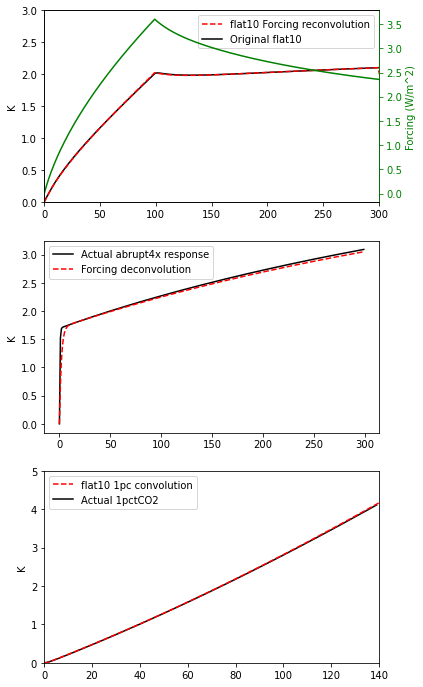

In [65]:
fig=plt.figure(figsize=[6,12])
ax1 = fig.add_subplot(312)

p1=ax1.plot(sfun(sopt.x,np.arange(0,300))*3.71*F_scale[0,0],'k')
p2=ax1.plot(T2x[:,0],'r--')
ax1.legend([p1[0],p2[0]],['Actual abrupt4x response','Forcing deconvolution'])
ax1.set_ylabel('K')

ax2 = fig.add_subplot(311)
p2=ax2.plot(Tcn0[:,0],'k')

p1=ax2.plot(signal.convolve(sfun(sopt.x,np.arange(0,300)),np.diff(F0)),'r--')


ax2.legend([p1[0],p2[0]],['flat10 Forcing reconvolution','Original flat10'])
ax2.set_ylabel('K')
ax2.set_xlim([0,300])
ax2.set_ylim([0,3])
ax2a = ax2.twinx()
ax2a.plot(F0,'g')

ax2a.set_ylabel('Forcing (W/m^2)', color='g')
ax2a.tick_params(axis='y', color='g', labelcolor='g')
ax2a.spines['right'].set_color('g')
ax3 = fig.add_subplot(313)

p2=ax3.plot(T1pc[:,0],'k')

p1=ax3.plot(signal.convolve(sfun(sopt.x,np.arange(0,300)),np.hstack((0,np.diff(F1pc)*F_scale[0,0]))),'r--')

ax3.legend([p1[0],p2[0]],['flat10 1pc convolution','Actual 1pctCO2'])
ax3.set_ylabel('K')
ax3.set_xlim([0,140])
ax3.set_ylim([0,5])


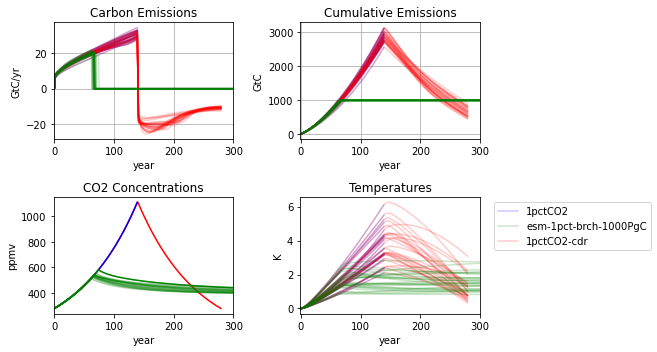

In [68]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(221)
p13=ax1.plot(range(140), E1, alpha=0.2, color='blue', label='1pctCO2')
p11=ax1.plot(range(280), Ecdr, alpha=0.2, color='red', label='1pctCO2-cdr')
p12=ax1.plot(range(300), Ezec, alpha=0.2, color='green', label='1pctCO2-cdr')
ax1.grid()
ax1.set_title("Carbon Emissions")
ax1.set_xlabel('year')
ax1.set_ylabel('GtC/yr')
ax1.set_xlim([-1,300])
ax1.set_xticks([0,100,200,300])


ax1c = fig.add_subplot(222)
p23=ax1c.plot(range(140), np.cumsum(E1,0), alpha=0.2, color='blue', label='1pctCO2')
p21=ax1c.plot(range(280), np.cumsum(Ecdr,0), alpha=0.2, color='red', label='1pctCO2-cdr')
p22=ax1c.plot(range(300), np.cumsum(Ezec,0), alpha=0.2, color='green', label='1pctCO2-cdr')
ax1c.grid()
ax1c.set_title("Cumulative Emissions")
ax1c.set_xlabel('year')
ax1c.set_ylabel('GtC')
ax1c.set_xlim([-1,300])
ax1c.set_xticks([0,100,200,300])


ax12 = fig.add_subplot(223)
p31=ax12.plot(range(280), Ccdr,  color='red', label='1pctCO2-cdr')
p33=ax12.plot(range(140), C,  color='blue', label='1pctCO2')
p32=ax12.plot(range(300), Czec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
p32=ax12.plot(range(300), Czec[:,0], color='green', label='esm-1pct-brch-1000PgC')
ax12.grid()

ax12.set_title("CO2 Concentrations")
ax12.set_xlabel('year')
ax12.set_ylabel('ppmv')
ax12.set_xlim([-1,300])
ax12.grid()
ax12.set_xticks([0,100,200,300])

ax13 = fig.add_subplot(224)
p41=ax13.plot(range(140), T1, alpha=0.2, color='blue', label='1pctCO2')
p42=ax13.plot(range(280), Tcdr, alpha=0.2, color='red', label='1pctCO2-cdr')
p43=ax13.plot(range(300), Tzec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
ax13.set_title("Temperatures")
ax13.set_xlabel('year')
ax13.set_ylabel('K')
ax13.set_xlim([-1,300])
ax13.set_xticks([0,100,200,300])


plt.tight_layout()
ax13.legend([p13[0],p12[0],p11[0]],['1pctCO2','esm-1pct-brch-1000PgC','1pctCO2-cdr'],bbox_to_anchor=(1.05, 1), loc='upper left')


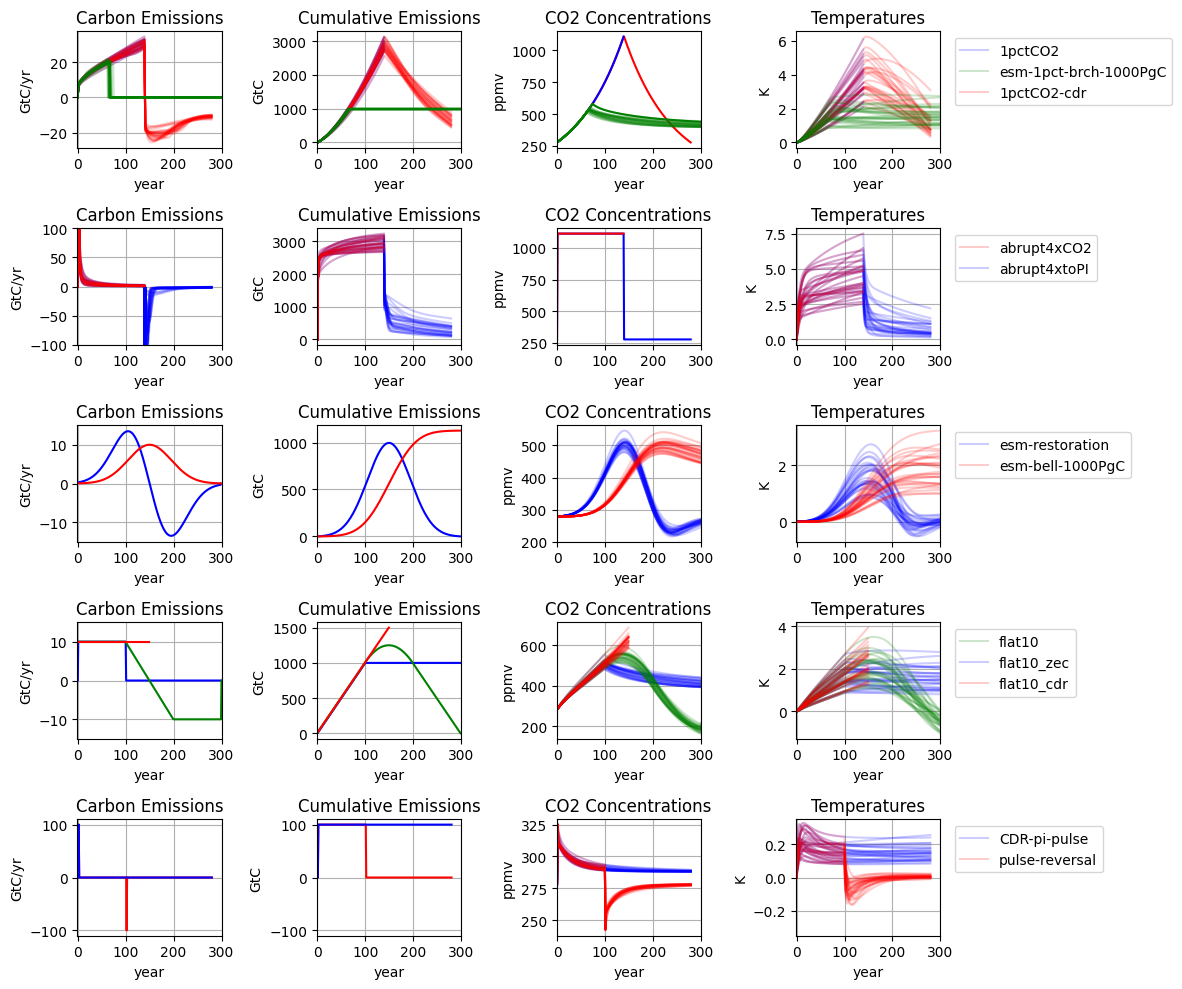

In [ ]:
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(551)
p13=ax1.plot(range(140), E1, alpha=0.2, color='blue', label='1pctCO2')
p11=ax1.plot(range(280), Ecdr, alpha=0.2, color='red', label='1pctCO2-cdr')
p12=ax1.plot(range(300), Ezec, alpha=0.2, color='green', label='1pctCO2-cdr')
ax1.grid()
ax1.set_title("Carbon Emissions")
ax1.set_xlabel('year')
ax1.set_ylabel('GtC/yr')
ax1.set_xlim([-1,300])
ax1.set_xticks([0,100,200,300])


ax1c = fig.add_subplot(552)
p23=ax1c.plot(range(140), np.cumsum(E1,0), alpha=0.2, color='blue', label='1pctCO2')
p21=ax1c.plot(range(280), np.cumsum(Ecdr,0), alpha=0.2, color='red', label='1pctCO2-cdr')
p22=ax1c.plot(range(300), np.cumsum(Ezec,0), alpha=0.2, color='green', label='1pctCO2-cdr')
ax1c.grid()
ax1c.set_title("Cumulative Emissions")
ax1c.set_xlabel('year')
ax1c.set_ylabel('GtC')
ax1c.set_xlim([-1,300])
ax1c.set_xticks([0,100,200,300])


ax12 = fig.add_subplot(553)
p31=ax12.plot(range(280), Ccdr,  color='red', label='1pctCO2-cdr')
p33=ax12.plot(range(140), C,  color='blue', label='1pctCO2')
p32=ax12.plot(range(300), Czec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
p32=ax12.plot(range(300), Czec[:,0], color='green', label='esm-1pct-brch-1000PgC')
ax12.grid()

ax12.set_title("CO2 Concentrations")
ax12.set_xlabel('year')
ax12.set_ylabel('ppmv')
ax12.set_xlim([-1,300])
ax12.grid()
ax12.set_xticks([0,100,200,300])

ax13 = fig.add_subplot(554)
p41=ax13.plot(range(140), T1, alpha=0.2, color='blue', label='1pctCO2')
p42=ax13.plot(range(280), Tcdr, alpha=0.2, color='red', label='1pctCO2-cdr')
p43=ax13.plot(range(300), Tzec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
ax13.set_title("Temperatures")
ax13.set_xlabel('year')
ax13.set_ylabel('K')
ax13.set_xlim([-1,300])
ax13.set_xticks([0,100,200,300])

ax2 = fig.add_subplot(556)
p51=ax2.plot(range(280), Erev, alpha=0.2, color='blue', label='1pctCO2')
p52=ax2.plot(range(140), Eabr, alpha=0.2, color='red', label='1pctCO2')
ax2.grid()

ax2.set_title("Carbon Emissions")
ax2.set_xlabel('year')
ax2.set_ylabel('GtC/yr')
ax2.set_ylim([-100,100])
ax2.set_xlim([-1,300])
ax2.set_xticks([0,100,200,300])

ax2c = fig.add_subplot(557)
p61=ax2c.plot(range(280), np.cumsum(Erev,0), alpha=0.2, color='blue', label='1pctCO2')
p62=ax2c.plot(range(140), np.cumsum(Eabr,0), alpha=0.2, color='red', label='1pctCO2')
ax2c.grid()

ax2c.set_title("Cumulative Emissions")
ax2c.set_xlabel('year')
ax2c.set_ylabel('GtC')
ax2c.set_xlim([-1,300])
ax2c.set_xticks([0,100,200,300])

ax22 = fig.add_subplot(558)
p71=ax22.plot(range(280), Crev,  color='blue', label='1pctCO2')
p72=ax22.plot(range(140), Cabr, color='red', label='1pctCO2')

ax22.set_title("CO2 Concentrations")
ax22.set_xlabel('year')
ax22.set_ylabel('ppmv')
ax22.set_xlim([-1,300])
ax22.set_xticks([0,100,200,300])

ax22.grid()

ax23 = fig.add_subplot(559)
p81=ax23.plot(range(280), Trev, alpha=0.2, color='blue', label='1pctCO2')
p82=ax23.plot(range(140), Tabr, alpha=0.2, color='red', label='1pctCO2')

ax23.set_title("Temperatures")
ax23.set_xlabel('year')
ax23.set_ylabel('K')
ax23.set_xlim([-1,300])
ax23.set_xticks([0,100,200,300])

ax23.grid()

ax3 = fig.add_subplot(5,5,11)
p91=ax3.plot(range(300), Echr,  color='blue', label='1pctCO2')
p92=ax3.plot(range(300), Ezb, color='red', label='1pctCO2')

ax3.set_title("Carbon Emissions")
ax3.set_xlabel('year')
ax3.set_ylabel('GtC/yr')
ax3.set_ylim([-15,15])
ax3.set_xlim([-1,300])
ax3.set_xticks([0,100,200,300])

ax3.grid()

ax3c = fig.add_subplot(5,5,12)
p101=ax3c.plot(range(300), np.cumsum(Echr,0),  color='blue', label='1pctCO2')
p102=ax3c.plot(range(300), np.cumsum(Ezb,0), color='red', label='1pctCO2')

ax3c.set_title("Cumulative Emissions")
ax3c.set_xlabel('year')
ax3c.set_ylabel('GtC')
ax3c.set_xlim([-1,300])
ax3c.set_xticks([0,100,200,300])

#ax3c.legend([p1[0],p2[0]],['esm-restoration','esm-bell-1000PgC'])
ax3c.grid()

ax32 = fig.add_subplot(5,5,13)
p111=ax32.plot(range(300), Cchr, alpha=0.2, color='blue', label='1pctCO2')
p112=ax32.plot(range(300), Czb, alpha=0.2, color='red', label='1pctCO2')

ax32.set_title("CO2 Concentrations")
ax32.set_xlabel('year')
ax32.set_ylabel('ppmv')
ax32.set_xlim([-1,300])
ax32.set_xticks([0,100,200,300])

ax32.grid()

ax33 = fig.add_subplot(5,5,14)
p121=ax33.plot(range(300), Tchr, alpha=0.2, color='blue', label='1pctCO2')
p122=ax33.plot(range(300), Tzb, alpha=0.2, color='red', label='1pctCO2')

ax33.set_title("Temperatures")
ax33.set_xlabel('year')
ax33.set_ylabel('K')
ax33.set_xlim([-1,300])
ax33.set_xticks([0,100,200,300])

ax33.grid()

ax4 = fig.add_subplot(5,5,16)
p131=ax4.plot(range(321), np.concatenate([[0],Ecn0]), color='blue', label='1pctCO2')
p133=ax4.plot(range(320), Ecdf, color='green', label='1pctCO2')
p132=ax4.plot(range(150), Ecns, color='red', label='1pctCO2')


ax4.set_title("Carbon Emissions")
ax4.set_xlabel('year')
ax4.set_ylabel('GtC/yr')
ax4.set_ylim([-15,15])
ax4.set_xlim([-1,300])
ax4.set_xticks([0,100,200,300])

ax4.grid()


ax4c = fig.add_subplot(5,5,17)
p141=ax4c.plot(range(321), np.cumsum(np.concatenate([[0],Ecn0]),0), color='blue', label='1pctCO2')
p143=ax4c.plot(range(320), np.cumsum(Ecdf,0), color='green', label='1pctCO2')
p142=ax4c.plot(range(150), np.cumsum(Ecns,0), color='red', label='1pctCO2')

#ax4c.legend([p2[0],p1[0],p3[0]],['flat10','flat10_zec','flat10_cdr'])

ax4c.set_title("Cumulative Emissions")
ax4c.set_xlabel('year')
ax4c.set_ylabel('GtC')
ax4c.set_xlim([-1,300])
ax4c.set_xticks([0,100,200,300])

ax4c.grid()


ax42 = fig.add_subplot(5,5,18)
p151=ax42.plot(range(320), Ccn0, alpha=0.2, color='blue', label='1pctCO2')
p152=ax42.plot(range(320), Ccdf, alpha=0.2, color='green', label='1pctCO2')
p153=ax42.plot(range(150), Ccns, alpha=0.2, color='red', label='1pctCO2')

ax42.grid()

ax42.set_title("CO2 Concentrations")
ax42.set_xlabel('year')
ax42.set_ylabel('ppmv')
ax42.set_xlim([-1,300])
ax42.set_xticks([0,100,200,300])

ax43 = fig.add_subplot(5,5,19)
p161=ax43.plot(range(320), Tcn0, alpha=0.2, color='blue', label='1pctCO2')
p162=ax43.plot(range(320), Tcdf, alpha=0.2, color='green', label='1pctCO2')
p163=ax43.plot(range(150), Tcns, alpha=0.2, color='red', label='1pctCO2')
ax43.grid()

ax43.set_title("Temperatures")
ax43.set_xlabel('year')
ax43.set_ylabel('K')
ax43.set_xlim([-1,300])
ax43.set_xticks([0,100,200,300])


ax5 = fig.add_subplot(5,5,21)
p172=ax5.plot(range(281), np.concatenate([[0],Ejoosr]), color='red', label='1pctCO2')

p171=ax5.plot(range(281), np.concatenate([[0],Ejoos]), color='blue', label='1pctCO2')
ax5.grid()

ax5.set_title("Carbon Emissions")
ax5.set_xlabel('year')
ax5.set_ylabel('GtC/yr')
ax5.set_ylim([-110,110])
ax5.set_xlim([-1,300])
ax5.set_xticks([0,100,200,300])

ax5c = fig.add_subplot(5,5,22)
p182=ax5c.plot(range(281), np.cumsum(np.concatenate([[0],Ejoosr]),0), color='red', label='1pctCO2')

p181=ax5c.plot(range(281), np.cumsum(np.concatenate([[0],Ejoos]),0), color='blue', label='1pctCO2')
#ax5c.legend([p1[0],p2[0]],['CDR-pi-pulse','pulse-reversal'])
ax5c.grid()

ax5c.set_title("Cumulative Emissions")
ax5c.set_xlabel('year')
ax5c.set_ylabel('GtC')
ax5c.set_ylim([-110,110])
ax5c.set_xlim([-1,300])
ax5c.set_xticks([0,100,200,300])

ax52 = fig.add_subplot(5,5,23)
p191=ax52.plot(range(280), Cjoos, alpha=0.2, color='blue', label='1pctCO2')
p192=ax52.plot(range(280), Cjoosr, alpha=0.2, color='red', label='1pctCO2')
ax52.grid()

ax52.set_title("CO2 Concentrations")
ax52.set_xlabel('year')
ax52.set_ylabel('ppmv')
ax52.set_xlim([-1,300])
ax52.set_xticks([0,100,200,300])

ax53 = fig.add_subplot(5,5,24)
p201=ax53.plot(range(280), Tjoos, alpha=0.2, color='blue', label='1pctCO2')
p202=ax53.plot(range(280), Tjoosr, alpha=0.2, color='red', label='1pctCO2')
ax53.grid()

ax53.set_title("Temperatures")
ax53.set_xlabel('year')
ax53.set_ylabel('K')
ax53.set_xlim([-1,300])
ax53.set_ylim([-.35,.35])
ax53.set_xticks([0,100,200,300])


plt.tight_layout()
ax13.legend([p13[0],p12[0],p11[0]],['1pctCO2','esm-1pct-brch-1000PgC','1pctCO2-cdr'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax23.legend([p82[0],p81[0]],['abrupt4xCO2','abrupt4xtoPI'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax33.legend([p121[0],p122[0]],['esm-restoration','esm-bell-1000PgC'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax43.legend([p162[0],p161[0],p163[0]],['flat10','flat10_zec','flat10_cdr'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax53.legend([p201[0],p202[0]],['CDR-pi-pulse','pulse-reversal'],bbox_to_anchor=(1.05, 1), loc='upper left')


(-1.0, 280.0)

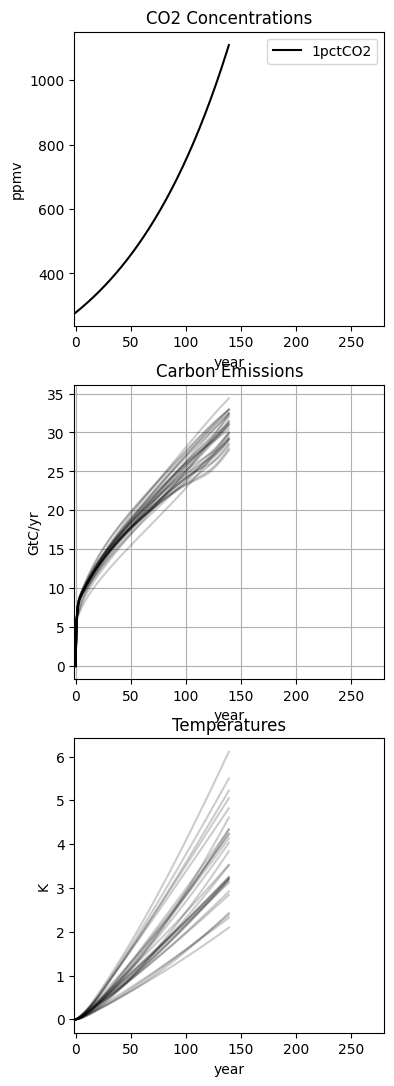

In [ ]:
fig = plt.figure(figsize=[4,13])
ax1 = fig.add_subplot(312)
p3=ax1.plot(range(140), E1, alpha=0.2, color='k', label='1pctCO2')
#p1=ax1.plot(range(280), Ecdr, alpha=0.2, color='red', label='1pctCO2-cdr')
#p2=ax1.plot(range(300), Ezec, alpha=0.2, color='green', label='1pctCO2-cdr')
ax1.grid()
ax1.set_title("Carbon Emissions")
ax1.set_xlabel('year')
ax1.set_ylabel('GtC/yr')
ax1.set_xlim([-1,280])

ax12 = fig.add_subplot(311)
#p1=ax12.plot(range(280), Ccdr,  color='red', label='1pctCO2-cdr')
p3=ax12.plot(range(140), C,  color='k', label='1pctCO2')
#p2=ax12.plot(range(300), Czec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
#p2=ax12.plot(range(300), Czec[:,0], color='green', label='esm-1pct-brch-1000PgC')
ax12.grid()

ax12.set_title("CO2 Concentrations")
ax12.set_xlabel('year')
ax12.set_ylabel('ppmv')
ax12.set_xlim([-1,280])
ax12.legend([p3[0]],['1pctCO2'])
ax12.grid()

ax13 = fig.add_subplot(313)
ax13.plot(range(140), T1, alpha=0.2, color='k', label='1pctCO2')
#ax13.plot(range(280), Tcdr, alpha=0.2, color='red', label='1pctCO2-cdr')
#ax13.plot(range(300), Tzec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
ax13.set_title("Temperatures")
ax13.set_xlabel('year')
ax13.set_ylabel('K')
ax13.set_xlim([-1,280])

(-1.0, 280.0)

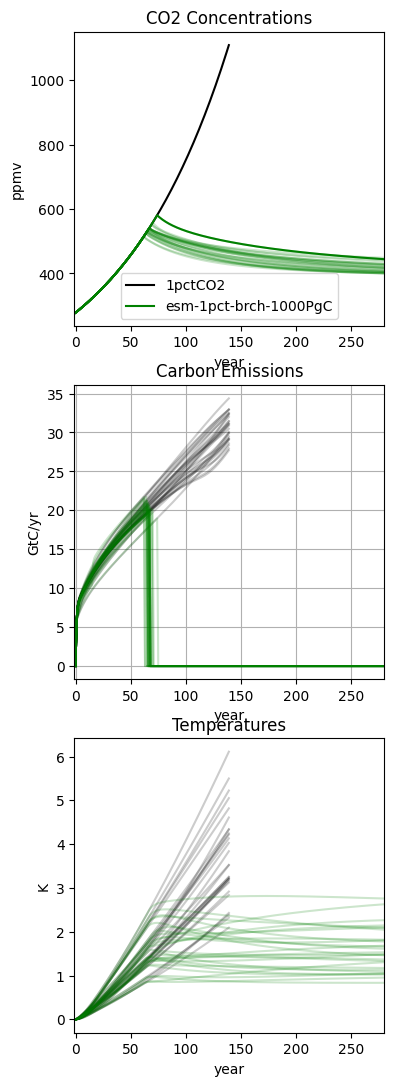

In [ ]:
fig = plt.figure(figsize=[4,13])
ax1 = fig.add_subplot(312)
p3=ax1.plot(range(140), E1, alpha=0.2, color='k', label='1pctCO2')
#p1=ax1.plot(range(280), Ecdr, alpha=0.2, color='red', label='1pctCO2-cdr')
p2=ax1.plot(range(300), Ezec, alpha=0.2, color='green', label='1pctCO2-cdr')
ax1.grid()
ax1.set_title("Carbon Emissions")
ax1.set_xlabel('year')
ax1.set_ylabel('GtC/yr')
ax1.set_xlim([-1,280])

ax12 = fig.add_subplot(311)
#p1=ax12.plot(range(280), Ccdr,  color='red', label='1pctCO2-cdr')
p3=ax12.plot(range(140), C,  color='k', label='1pctCO2')
p2=ax12.plot(range(300), Czec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
p2=ax12.plot(range(300), Czec[:,0], color='green', label='esm-1pct-brch-1000PgC')
ax12.grid()

ax12.set_title("CO2 Concentrations")
ax12.set_xlabel('year')
ax12.set_ylabel('ppmv')
ax12.set_xlim([-1,280])
ax12.legend([p3[0],p2[0]],['1pctCO2','esm-1pct-brch-1000PgC'])
ax12.grid()

ax13 = fig.add_subplot(313)
ax13.plot(range(140), T1, alpha=0.2, color='k', label='1pctCO2')
#ax13.plot(range(280), Tcdr, alpha=0.2, color='red', label='1pctCO2-cdr')
ax13.plot(range(300), Tzec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
ax13.set_title("Temperatures")
ax13.set_xlabel('year')
ax13.set_ylabel('K')
ax13.set_xlim([-1,280])

(-1.0, 280.0)

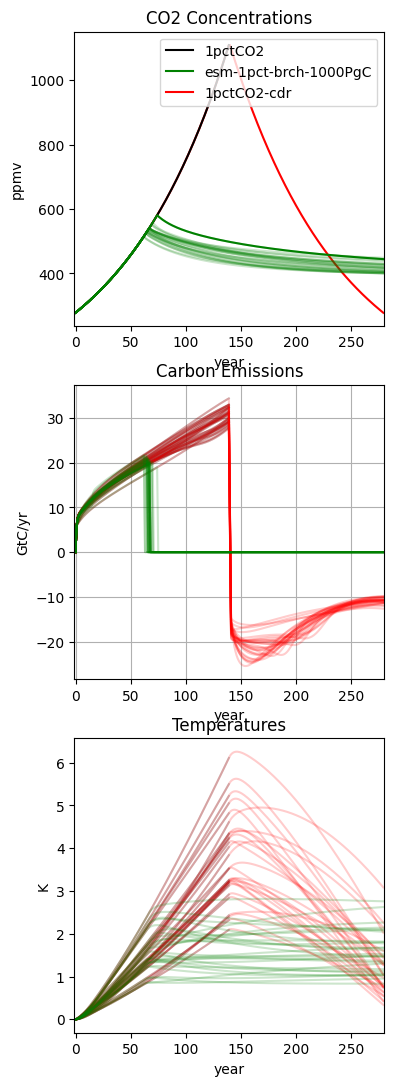

In [ ]:
fig = plt.figure(figsize=[4,13])
ax1 = fig.add_subplot(312)
p3=ax1.plot(range(140), E1, alpha=0.2, color='k', label='1pctCO2')
p1=ax1.plot(range(280), Ecdr, alpha=0.2, color='red', label='1pctCO2-cdr')
p2=ax1.plot(range(300), Ezec, alpha=0.2, color='green', label='1pctCO2-cdr')
ax1.grid()
ax1.set_title("Carbon Emissions")
ax1.set_xlabel('year')
ax1.set_ylabel('GtC/yr')
ax1.set_xlim([-1,280])

ax12 = fig.add_subplot(311)
p1=ax12.plot(range(280), Ccdr,  color='red', label='1pctCO2-cdr')
p3=ax12.plot(range(140), C,  color='k', label='1pctCO2')
p2=ax12.plot(range(300), Czec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
p2=ax12.plot(range(300), Czec[:,0], color='green', label='esm-1pct-brch-1000PgC')
ax12.grid()

ax12.set_title("CO2 Concentrations")
ax12.set_xlabel('year')
ax12.set_ylabel('ppmv')
ax12.set_xlim([-1,280])
ax12.legend([p3[0],p2[0],p1[0]],['1pctCO2','esm-1pct-brch-1000PgC','1pctCO2-cdr'])
ax12.grid()

ax13 = fig.add_subplot(313)
ax13.plot(range(140), T1, alpha=0.2, color='k', label='1pctCO2')
ax13.plot(range(280), Tcdr, alpha=0.2, color='red', label='1pctCO2-cdr')
ax13.plot(range(300), Tzec, alpha=0.2, color='green', label='esm-1pct-brch-1000PgC')
ax13.set_title("Temperatures")
ax13.set_xlabel('year')
ax13.set_ylabel('K')
ax13.set_xlim([-1,280])